## Import Dependencies

In [99]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vgg16

In [100]:
# Device Agnostic Code
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Initialization

In [101]:
# View first few rows of train csv
train_df = pd.read_csv("/kaggle/input/ripik-hackfest/train/train/train.csv")
train_df.head()

,image_id,filename,label
0,1,1.jpg,2
1,2,2.jpg,4
2,3,3.jpg,2
3,4,4.jpg,3
4,5,5.jpg,5


In [102]:
# Create dictionary for sparse label to corresponding item for plotting
labels_dict = {
    0: "crack",
    1: "scratch",
    2: "tire flat",
    3: "dent",
    4: "glass shatter",
    5: "lamp broken"
}

In [103]:
# View data type of train_df
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  7200 non-null   int64 
 1   filename  7200 non-null   object
 2   label     7200 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 168.9+ KB


In [104]:
# Adjust the labels to start at 0
train_df["label"] = train_df["label"] - 1

In [105]:
# View class label distribution
train_df["label"].value_counts()

label
1    2349
3    2079
4    1185
5     882
2     534
0     171
Name: count, dtype: int64

The big imbalance in class would indicate a Random Weighted Sampler, data augmentation, or class weights may be needed

## Sample Data Visualization

In [106]:
# Function to View a Few Images
def view_sample_images(input_image_dir, dataframe, n_samples=5):
    sample_df = dataframe.sample(n_samples)
    num_rows = math.ceil(n_samples / 5)
    num_cols = 5
    fig = plt.figure(figsize = (15,10))
    for i in range(n_samples):
        ax = plt.subplot(num_rows, num_cols, i+1)
        file_name = os.path.join(input_image_dir, sample_df.iloc[i]["filename"])
        class_label = sample_df.iloc[i]["label"]
        class_category = labels_dict[class_label]
        img = cv2.imread(file_name)
        ax.imshow(img)
        ax.set_title(f"Class: {class_label} ({class_category})")
    plt.tight_layout()
    plt.show()

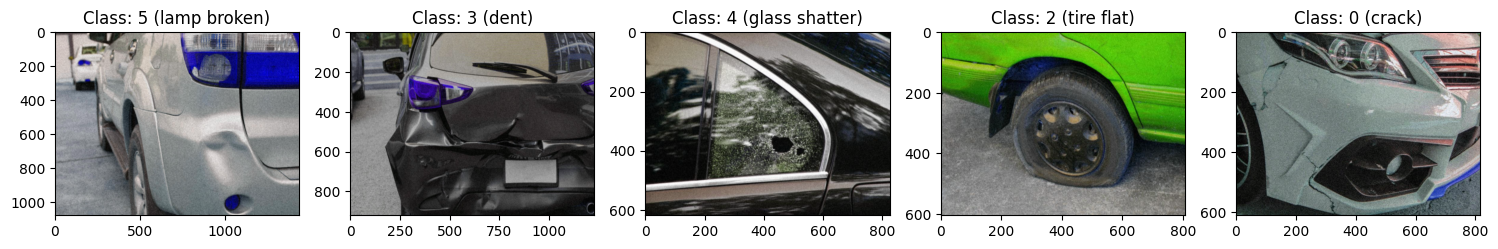

In [107]:
# View five images
N_SAMPLES = 5
view_sample_images("/kaggle/input/ripik-hackfest/train/train/images", train_df, N_SAMPLES)

## Data Preparation

In [108]:
# Create Custom Dataset
class VehicleImageLoader(Dataset):
    def __init__(self, dataframe, root_dir, transforms = None):
        self.annotations = dataframe
        self.transforms = transforms
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.annotations)
    
    def  __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx]["filename"])
        img = cv2.imread(img_path)
        label = self.annotations.iloc[idx]["label"]
        
        if self.transforms:
            img = self.transforms(img)
            
        return (img, label)

In [109]:
# Create transforms pipeline
transform_pipeline = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [110]:
# Create dataset
dataset = VehicleImageLoader(train_df, "/kaggle/input/ripik-hackfest/train/train/images", transforms = transform_pipeline)

In [111]:
# Partition the train dataset into train and validation
TRAIN_SPLIT = 0.80

num_train = int(TRAIN_SPLIT * len(dataset))
num_validation = len(dataset) - num_train
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [num_train, num_validation])

In [112]:
# Create the dataloaders
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [113]:
# View first batch
data_iter = iter(train_dataloader)
batch = next(data_iter)
batch[0].shape, batch[1].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Data Modeling

In [115]:
# Initialize Pretrained Model
model = vgg16(weights="VGG16_Weights.DEFAULT")

In [116]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Fine-tuning model

In [117]:
# Change classifier final output
num_classes = train_df["label"].nunique()
model.classifier[6] = nn.Linear(in_features = 4096, out_features = num_classes, bias = True)

In [118]:
# Sent model to device
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Optimizer and Loss Function

In [119]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = "min", factor = 0.2, patience = 2, verbose = True)

In [120]:
def check_accuracy(y_pred_logits, y_true):
    predictions = torch.argmax(y_pred_logits, dim = 1)
    accuracy = accuracy_score(y_true.cpu().numpy(), predictions.cpu().numpy())
    
    return accuracy

In [121]:
# Basic training function
# for _ in range(4):
#     X, y = batch
#     y_pred = model(X)
#     loss = criterion(y_pred, y)
#     print(loss)
#     accuracy = check_accuracy(y_pred, y)
#     print("Accuracy:",accuracy)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

### Creating Training Function

In [122]:
def train_step(model, train_loader, val_loader, optimizer, criterion, num_epochs, total_patience = 5, device = device):
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    
    best_val_loss = float("inf")
    patience = 0
    
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_acc = 0
        loop = tqdm(enumerate(train_loader), total = len(train_loader), leave = False)
        for batch, (X, y) in loop:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # Get predictions
            y_pred = model(X)
            
            # Calulcate loss
            train_loss = criterion(y_pred, y)
            total_train_loss += train_loss.item()
            
            # Get accuracy
            batch_accuracy = check_accuracy(y_pred, y)
            total_train_acc += batch_accuracy
            
            # Zero optimizer
            optimizer.zero_grad()
            
            # Backpropagation
            train_loss.backward()
            
            # Gradient Descent
            optimizer.step()
            
            # Update Progress Bar
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss = train_loss.item(), acc = batch_accuracy)
                 
        # Calculate total loss value (average of all batches)   
        average_train_loss = total_train_loss / len(train_loader)
        train_losses.append(average_train_loss)
        
        # calculate total accuracy
        average_train_accuracy = total_train_acc / len(train_loader)
        train_accuracy.append(average_train_accuracy)
        
        # Check Validation
        model.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.inference_mode():
            val_loop = tqdm(enumerate(val_loader), total = len(val_dataloader), leave = False)
            for batch, (X,y) in val_loop:
                X, y = X.to(device), y.to(device)
                
                y_pred = model(X)
                
                val_loss = criterion(y_pred, y)
                total_val_loss += val_loss.item()
                
                batch_accuracy = check_accuracy(y_pred, y)
                total_val_acc += batch_accuracy
                
                val_loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
                val_loop.set_postfix(loss = val_loss.item(), acc = batch_accuracy)
                  
        average_val_loss = total_val_loss / len(val_loader)
        val_losses.append(average_val_loss)
        
        average_val_accuracy = total_val_acc / len(val_loader)
        val_accuracy.append(average_val_accuracy)
        
        
        # Early Stopping and Model Checkpoint
        if average_val_loss < best_val_loss:
            print(f"Validation Loss Improved From: {best_val_loss} to {average_val_loss}")
            best_val_loss = average_val_loss
            
            # Save entire model
            torch.save(model.state_dict(), "vehicle_classification_weights.pth")
            print("Saved Weights to vehicle_classification_weights.pth")
            
            patience = 0
        else:
            print("Validation Loss Did not Improve")
            patience += 1
            
            if patience == total_patience:
                print("End Training: Early Stopping")
                print(f"Epoch: {epoch+1} | Train Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f} | Train Accuracy: {average_train_accuracy:.4f} | Validation Accuracy: {average_val_accuracy:.4f}")
                break
        scheduler.step(average_val_loss)       
        print(f"Epoch: {epoch+1} | Train Loss: {average_train_loss:.4f} | Validation Loss: {average_val_loss:.4f} | Train Accuracy: {average_train_accuracy:.4f} | Validation Accuracy: {average_val_accuracy:.4f}")
    return {"Train Accuracy" : train_accuracy, "Validation Accuracy" : val_accuracy, "Train Loss" : train_losses, "Validation Loss" : val_losses}

In [123]:
# Deterministic Behavior
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Training
NUM_EPOCHS = 20
history = train_step(model, train_dataloader, val_dataloader, optimizer, criterion, NUM_EPOCHS)

  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Improved From: inf to 0.5964521209398905
Saved Weights to vehicle_classification_weights.pth
Epoch: 1 | Train Loss: 0.7898 | Validation Loss: 0.5965 | Train Accuracy: 0.6931 | Validation Accuracy: 0.7653


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Improved From: 0.5964521209398905 to 0.3644776271449195
Saved Weights to vehicle_classification_weights.pth
Epoch: 2 | Train Loss: 0.3749 | Validation Loss: 0.3645 | Train Accuracy: 0.8609 | Validation Accuracy: 0.8715


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Improved From: 0.3644776271449195 to 0.32718696396590935
Saved Weights to vehicle_classification_weights.pth
Epoch: 3 | Train Loss: 0.1553 | Validation Loss: 0.3272 | Train Accuracy: 0.9481 | Validation Accuracy: 0.9118


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 4 | Train Loss: 0.1019 | Validation Loss: 0.3580 | Train Accuracy: 0.9632 | Validation Accuracy: 0.9000


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Improved From: 0.32718696396590935 to 0.24001467005970578
Saved Weights to vehicle_classification_weights.pth
Epoch: 5 | Train Loss: 0.0808 | Validation Loss: 0.2400 | Train Accuracy: 0.9733 | Validation Accuracy: 0.9194


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 6 | Train Loss: 0.0548 | Validation Loss: 0.3354 | Train Accuracy: 0.9818 | Validation Accuracy: 0.9222


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 7 | Train Loss: 0.0328 | Validation Loss: 0.2609 | Train Accuracy: 0.9896 | Validation Accuracy: 0.9437


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch 00008: reducing learning rate of group 0 to 2.0000e-05.
Epoch: 8 | Train Loss: 0.0352 | Validation Loss: 0.2825 | Train Accuracy: 0.9899 | Validation Accuracy: 0.9250


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Improved From: 0.24001467005970578 to 0.23912725676006327
Saved Weights to vehicle_classification_weights.pth
Epoch: 9 | Train Loss: 0.0068 | Validation Loss: 0.2391 | Train Accuracy: 0.9977 | Validation Accuracy: 0.9549


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 10 | Train Loss: 0.0005 | Validation Loss: 0.2499 | Train Accuracy: 1.0000 | Validation Accuracy: 0.9556


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 11 | Train Loss: 0.0003 | Validation Loss: 0.2567 | Train Accuracy: 1.0000 | Validation Accuracy: 0.9563


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch 00012: reducing learning rate of group 0 to 4.0000e-06.
Epoch: 12 | Train Loss: 0.0002 | Validation Loss: 0.2662 | Train Accuracy: 1.0000 | Validation Accuracy: 0.9569


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
Epoch: 13 | Train Loss: 0.0002 | Validation Loss: 0.2675 | Train Accuracy: 1.0000 | Validation Accuracy: 0.9563


  0%|          | 0/180 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

Validation Loss Did not Improve
End Training: Early Stopping
Epoch: 14 | Train Loss: 0.0002 | Validation Loss: 0.2691 | Train Accuracy: 1.0000 | Validation Accuracy: 0.9569


### Save Model and Other Parameters

In [124]:
# Save loss and accuracy
torch.save(history, "vehicle_classification_history.pth")

In [125]:
history

{'Train Accuracy': [0.6930555555555555,
  0.8609375,
  0.9480902777777778,
  0.9631944444444445,
  0.9732638888888889,
  0.9817708333333334,
  0.9895833333333334,
  0.9899305555555555,
  0.9977430555555555,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'Validation Accuracy': [0.7652777777777777,
  0.8715277777777778,
  0.9118055555555555,
  0.9,
  0.9194444444444444,
  0.9222222222222223,
  0.94375,
  0.925,
  0.9548611111111112,
  0.9555555555555556,
  0.95625,
  0.9569444444444445,
  0.95625,
  0.9569444444444445],
 'Train Loss': [0.7898271363642481,
  0.37487792368564343,
  0.15534486295137967,
  0.10192649732343853,
  0.08084063253902261,
  0.05480767961481534,
  0.03283797763579059,
  0.035188599860218044,
  0.006786507727701974,
  0.0005391900155852151,
  0.00030291119200127366,
  0.00021946390997982235,
  0.00016439187384346748,
  0.00017632293595902916],
 'Validation Loss': [0.5964521209398905,
  0.3644776271449195,
  0.32718696396590935,
  0.3579983885917399,
  0.24001467005970578,
  0

## Model Performance

In [126]:
# Load the model
model = vgg16(weights="VGG16_Weights.DEFAULT")
model.classifier[6] = nn.Linear(in_features = 4096, out_features = num_classes, bias = True)
model.load_state_dict(torch.load("vehicle_classification_weights.pth"))

# Load the history
history = torch.load("vehicle_classification_history.pth")

### Model Loss and Accuracy

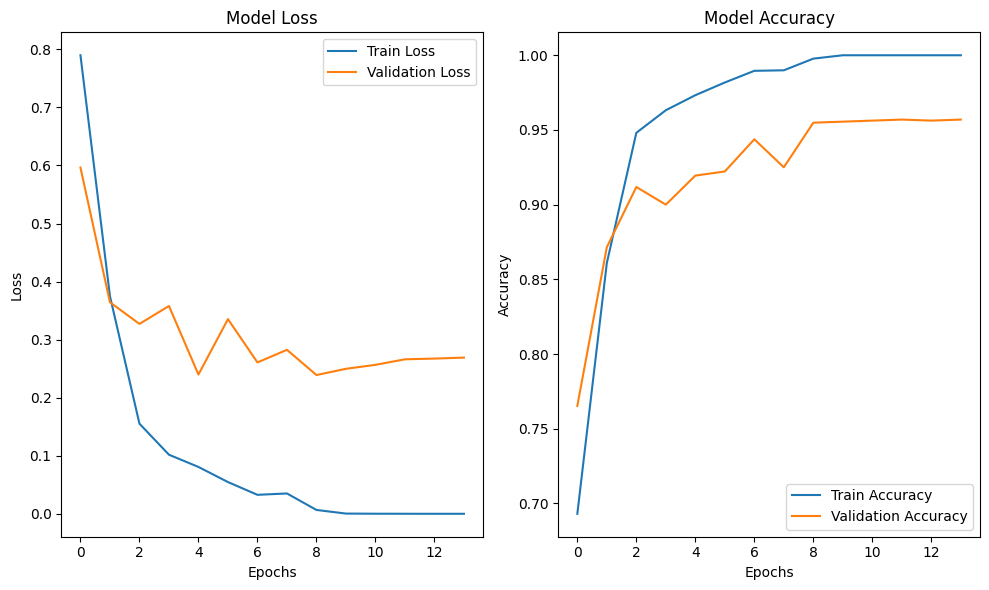

In [127]:
# Plot the loss and accuracies
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,6))

# Loss Values
axes[0].plot(history["Train Loss"], label = "Train Loss")
axes[0].plot(history["Validation Loss"], label = "Validation Loss")
axes[0].set_title("Model Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

axes[1].plot(history["Train Accuracy"], label = "Train Accuracy")
axes[1].plot(history["Validation Accuracy"], label = "Validation Accuracy")
axes[1].set_title("Model Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

### Confusion Matrix

In [128]:
# Get predictions
model.to(device)
model.eval()
true_labels = []
pred_labels = []

with torch.inference_mode():
    for batch, (X, y) in enumerate(val_dataloader):
        X, y = X.to(device), y.to(device)
        logits = model(X)
        prediction = torch.argmax(logits, dim = 1)
        
        # Append to lists
        true_labels.extend(y.cpu().numpy())
        pred_labels.extend(prediction.cpu().numpy())

In [129]:
# Convert lists to NumPy array
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

In [130]:
accuracy_score(true_labels, pred_labels)

0.9548611111111112

In [131]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

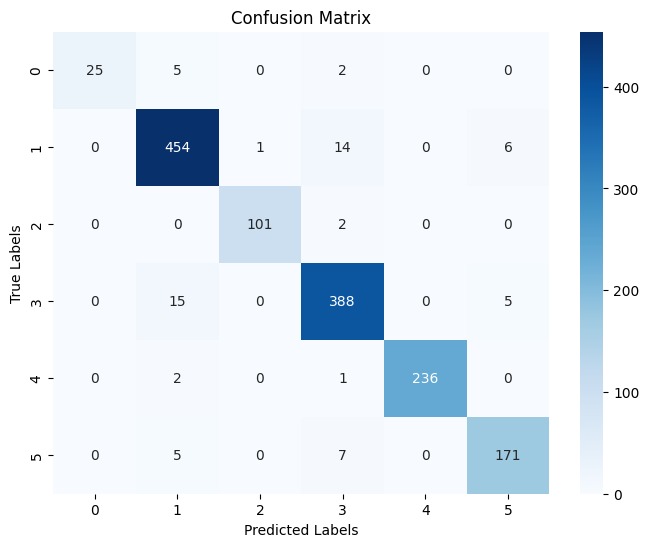

In [132]:
# Plot the confusion matrix as a seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Make Predictions

In [133]:
# Read in test csv
test_df = pd.read_csv("/kaggle/input/ripik-hackfest/test/test/test.csv")
test_df.head()

,image_id,filename
0,7201,7201.jpg
1,7202,7202.jpg
2,7203,7203.jpg
3,7204,7204.jpg
4,7205,7205.jpg


In [134]:
# Create full paths for all images
test_images_dir = "/kaggle/input/ripik-hackfest/test/test/images/"
test_df["filename"] = test_images_dir + test_df["filename"]

### Make Predictions

In [135]:
def make_predictions(dataframe, model, transforms, num_preds = 5):
    model.to("cpu")
    sample_df = dataframe.sample(num_preds)
    num_rows = math.ceil(num_preds / 5)
    num_cols = 5
    fig = plt.figure(figsize = (15,10))
    for i in range(num_preds):
        image_path = sample_df.iloc[i]["filename"]
        img = cv2.imread(image_path)
        ax = plt.subplot(num_rows, num_cols, i+1)
        img = transforms(img)
        model.eval()
        with torch.inference_mode():
            pred = model(img.unsqueeze(0))
            pred = torch.argmax(pred, dim = 1)
        ax.imshow(np.transpose(img, [1,2,0]))
        ax.set_title(f"Predicted: {labels_dict[pred.item()]}")
        

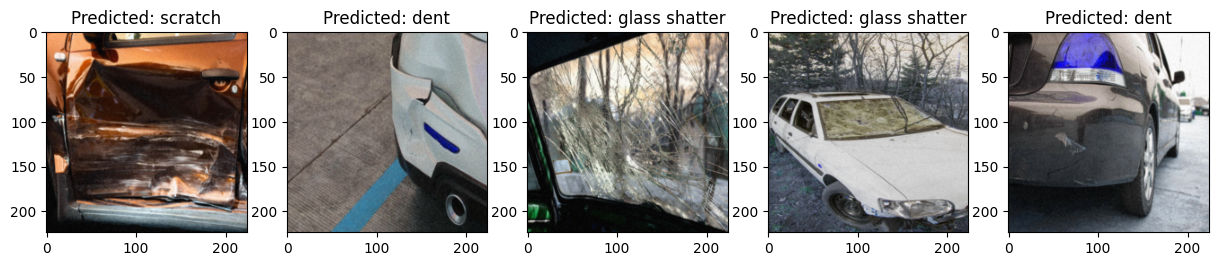

In [136]:
make_predictions(test_df, model, transform_pipeline)